# POC

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Note that I have renamed the data (CSV) files - removed the MOOC name from the file names.

In [291]:
archetype = pd.read_csv('archetype-survey-responses.csv', index_col='learner_id', parse_dates=['responded_at'])
comment = pd.read_csv('comments.csv', index_col='id', parse_dates=['timestamp'])
country = pd.read_csv('countries.csv', index_col='country_code')
enrol = pd.read_csv('enrolments.csv', index_col='learner_id', parse_dates=['enrolled_at', 'fully_participated_at'])
response = pd.read_csv('question-response.csv', parse_dates=['submitted_at'])
step = pd.read_csv('step-activity.csv', parse_dates=['first_visited_at', 'last_completed_at'])
video = pd.read_csv('video-stats.csv')

The majority of the data is a time series,
hence the majority of comparisons are best made by self joins at a different time,
e.g. compare this week with next week.
Self joins may be tricky to read in code,
and it may therefore be quite difficult to change.
There are several unneeded condition in the code that are placed
in order to make the code robust against corner cases.
If you are changing the code please leave theses conditions be
no matter how obvious it seems that these are not needed for the data
currently processed.

---

# Step Completion

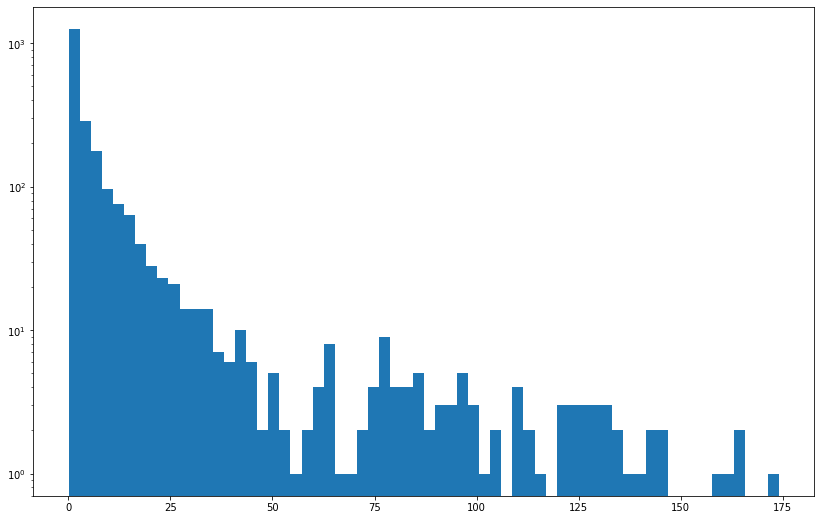

In [151]:
fig, ax = plt.subplots(figsize=(14, 9))
completed_time = (step.last_completed_at - step.first_visited_at).dt.seconds
three_hours = 60*60*3
completed_time = completed_time[completed_time < three_hours]
ax.hist(completed_time / 60, bins=64);
ax.set_yscale('log')
#ax.set_xlim([0, 120])

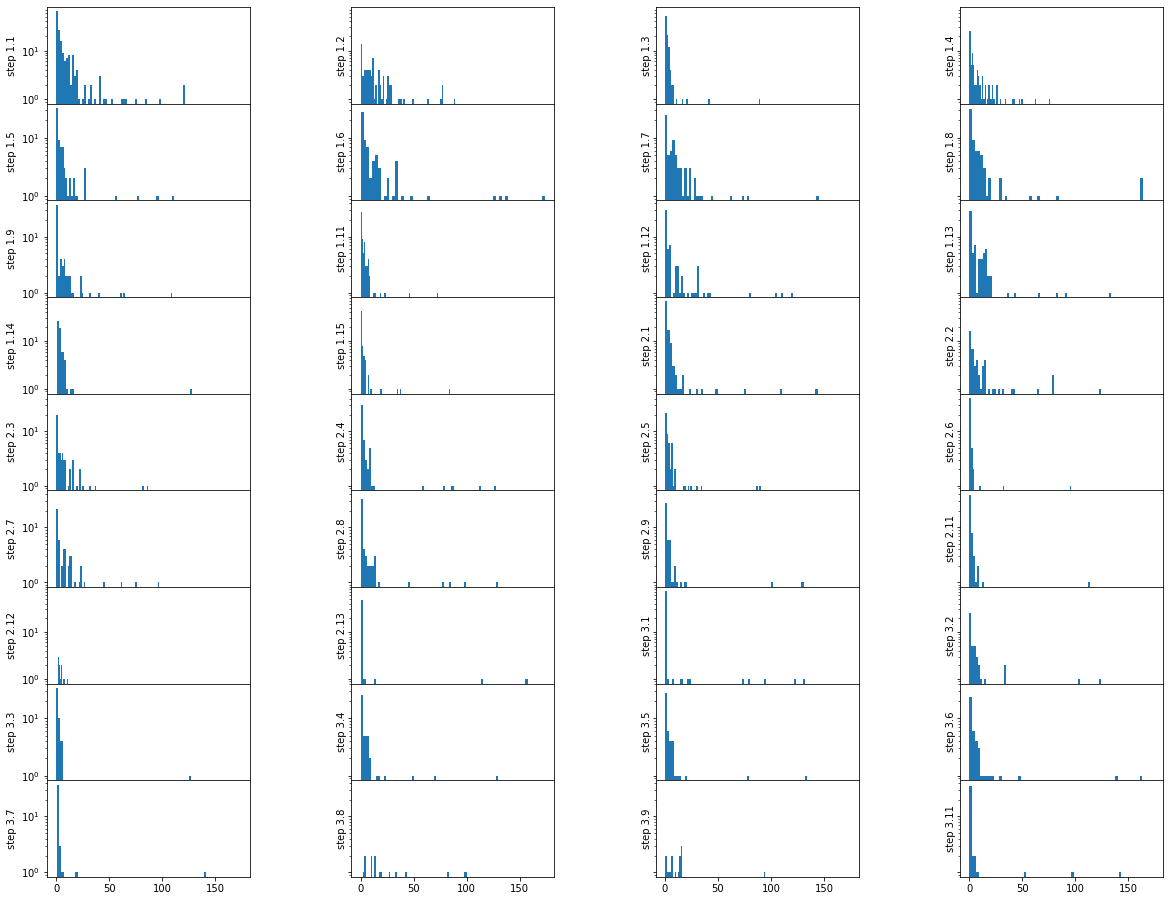

In [165]:
all_steps = step.step.unique()
completed_time = (step.last_completed_at - step.first_visited_at).dt.seconds
three_hours = 60*60*3
completed_time = step[completed_time < three_hours]
fig, ax = plt.subplots(len(all_steps)//4, 4, sharex=True, sharey='row', figsize=(20, 16))
for i, s in enumerate(all_steps):
    this_step = completed_time[completed_time.step == s]
    ax.flat[i].hist((this_step.last_completed_at - this_step.first_visited_at).dt.seconds / 60, bins=64)
    ax.flat[i].set_ylabel(f'step {s}')
    ax.flat[i].set_yscale('log')
plt.subplots_adjust(wspace=0.5, hspace=0)

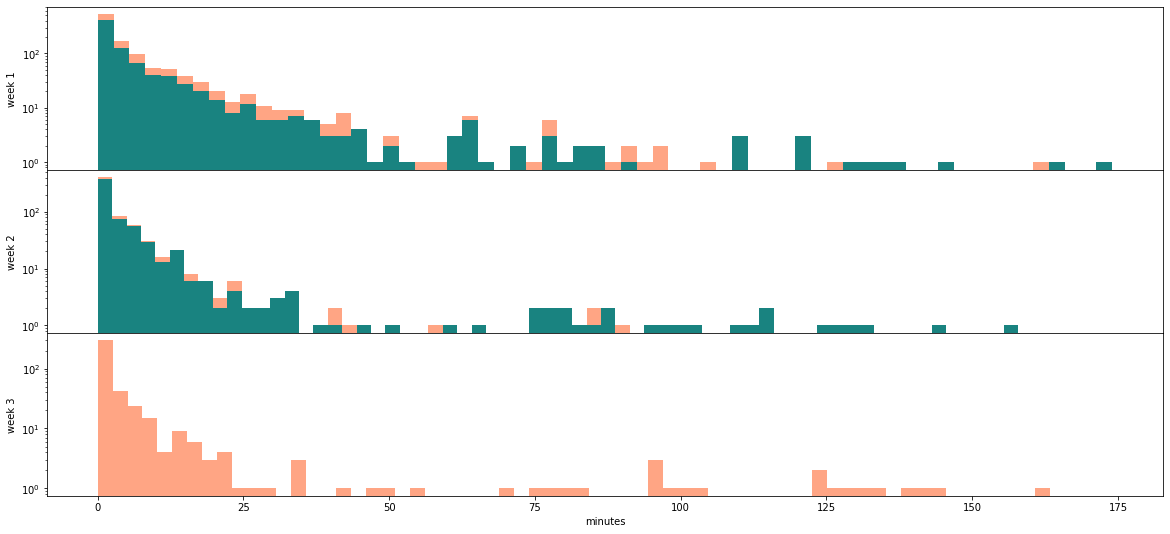

In [315]:
def plot_hist(step, week, ax):
    cur_step = step[step.week_number == week]
    next_step = step[step.week_number == week + 1][['learner_id', 'step']]
    if len(next_step):  # hardened code, the condition is not needed but just in case
        next_step = next_step.groupby('learner_id').count()
        next_step.columns = ['stayed']
        next_step['stayed'] = True
        next_step = next_step.reset_index()
        combined = pd.merge(cur_step, next_step, on='learner_id', how='left')
        combined['stayed'].fillna(False, inplace=True)
    else:
        combined = cur_step.copy()
        combined['stayed'] = False

    completed_time = (combined.last_completed_at - combined.first_visited_at).dt.seconds
    three_hours = 60*60*3
    completed_time = completed_time[completed_time < three_hours]
    _, bins, _ = ax.hist(completed_time / 60, bins=64, color='coral', alpha=.7)

    stayed = combined[combined.stayed]
    if len(stayed):  # again not needed, but leave it hardened just in case
        completed_time = (stayed.last_completed_at - stayed.first_visited_at).dt.seconds
        completed_time = completed_time[completed_time < three_hours]
        _, bins, _ = ax.hist(completed_time / 60, bins=bins, color='teal', alpha=.9)

    ax.set_ylabel(f'week {week}')
    ax.set_yscale('log')

n = 3
fig, ax = plt.subplots(n, 1, sharex=True, figsize=(20, 3*n))
plot_hist(step, 1, ax.flat[0])
plot_hist(step, 2, ax.flat[1])
plot_hist(step, 3, ax.flat[2])
ax.flat[2].set_xlabel('minutes')
plt.subplots_adjust(hspace=0)

## Graph 1: Mean time to complete a session each week

Each week (each graph) we see how many students have completed the assigned
steps within a certain number of minutes.
Each week less and less students complete the steps as students give up the MOOC.
Albeit students that spend little time on the step are more likely to give
up and not follow the next week.
The left hand side where the completion times are small decreases fast,
whilst the right hand side remains reasonably constant.

In orange we see the students that gave up that week
(in the last week all students give up as it is the end of the MOOC).
In green we see the students that stayed for the following week.
Not the vertical logarithmic scale,
the higher on the graph a difference between orange and green is present
the more students gave up.

The graphs above this one are the same students placed in completion time bins
but aggregated together (topmost graph) and aggregated separately per step.
A viable hypothesis is that at the very beginning students spend time on the
steps out of curiosity, later the time spent is likely proportional to
the engagement of a step/session.  Notably, steps 3.7, 3.8 and 3.9
appear to be quite engaging.

---

# Quiz Responses

In [257]:
# week.step.question (NOT week.question.step)
w1 = response.quiz_question == '1.3.1'
w2 = response.quiz_question == '2.6.2'
w3 = response.quiz_question == '3.7.3'
response

,learner_id,quiz_question,question_type,week_number,step_number,question_number,response,cloze_response,submitted_at,correct
0,db8e8cc4-e611-478c-8fdd-f0c9e83e8f7d,1.14.1,MultipleChoice,1,14,1,2,NaN,2021-04-14 14:49:27+00:00,False
1,6042d8af-09cd-4966-b559-56a0bd66113a,1.14.1,MultipleChoice,1,14,1,3,NaN,2021-05-03 09:37:09+00:00,True
2,eadc3ad1-2f04-4dd8-97c4-94311516fd67,1.14.1,MultipleChoice,1,14,1,1,NaN,2021-05-03 12:23:26+00:00,False
3,eadc3ad1-2f04-4dd8-97c4-94311516fd67,1.14.1,MultipleChoice,1,14,1,2,NaN,2021-05-03 12:23:28+00:00,False
4,eadc3ad1-2f04-4dd8-97c4-94311516fd67,1.14.1,MultipleChoice,1,14,1,3,NaN,2021-05-03 12:23:31+00:00,True
...,...,...,...,...,...,...,...,...,...,...
2298,021f47d6-2cf6-425e-a517-52ffcff3bfd1,3.7.4,MultipleChoice,3,7,4,3,NaN,2021-06-29 18:15:10+00:00,True
2299,7b523a49-cd08-481b-842e-0a3eb272a9f8,3.7.4,MultipleChoice,3,7,4,2,NaN,2021-07-08 21:48:11+00:00,True
2300,6e7c96bb-04f7-4e5b-9ae4-3434bc69daec,3.7.4,MultipleChoice,3,7,4,3,NaN,2021-07-12 11:27:49+00:00,True
2301,4f94b1e4-895d-419a-aedc-5c3686c47533,3.7.4,MultipleChoice,3,7,4,4,NaN,2021-07-13 14:00:56+00:00,True


The `response` column is quite messy.

In [258]:
response.question_type.unique()

array(['MultipleChoice'], dtype=object)

The questions are multiple choice,
sometimes people answer two things.

In [256]:
resp1 = response[w1].groupby('learner_id').aggregate([len, tuple])['response']
resp1[resp1.len == 2]

,len,tuple
learner_id,,
2ad1e766-3897-4bd2-a6ac-031ebcba79c9,2,"(1, 5)"
6528f04d-b76a-4e40-a526-bcaeeba92658,2,"(2, 4)"


In [300]:
quiz = response[['learner_id', 'quiz_question', 'response']].copy()
quiz.response = response.response.apply(lambda x: np.mean(list(map(int, x.split(',')))))
quiz = quiz.groupby(['learner_id', 'quiz_question']).mean()
quiz.reset_index(inplace=True)
quiz

,learner_id,quiz_question,response
0,0022e782-f726-4682-9a91-adb8401df949,1.14.1,3.0
1,0022e782-f726-4682-9a91-adb8401df949,1.14.2,2.0
2,0022e782-f726-4682-9a91-adb8401df949,1.14.3,1.0
3,0022e782-f726-4682-9a91-adb8401df949,1.14.4,2.5
4,0022e782-f726-4682-9a91-adb8401df949,1.14.5,2.0
...,...,...,...
1585,fc5bdb5c-6626-41bd-af5b-9e94f953a93b,2.6.2,5.0
1586,fc5bdb5c-6626-41bd-af5b-9e94f953a93b,3.7.1,5.0
1587,fc5bdb5c-6626-41bd-af5b-9e94f953a93b,3.7.2,5.0
1588,fc5bdb5c-6626-41bd-af5b-9e94f953a93b,3.7.3,5.0


In [301]:
w1 = quiz.quiz_question == '1.3.1'
w2 = quiz.quiz_question == '2.6.2'
w3 = quiz.quiz_question == '3.7.3'

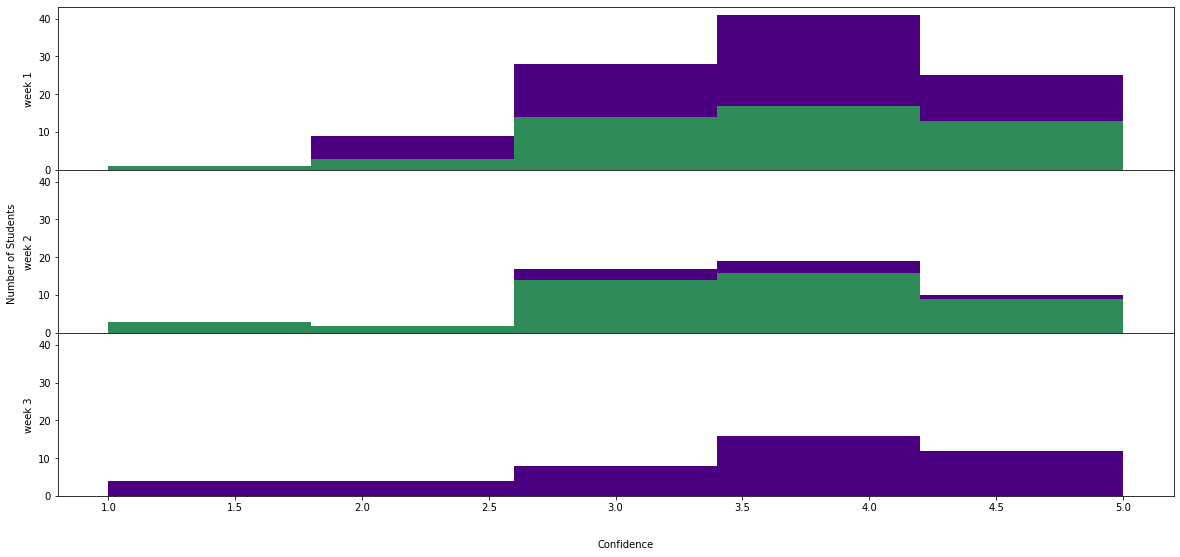

In [339]:
bins = int(quiz.response.max())

fig, axs = plt.subplots(n, 1, sharex=True, sharey=True, figsize=(20, 9))

qw1 = quiz[w1]
qw2 = quiz[w2]
qw3 = quiz[w3]

axs.flat[0].hist(qw1.response, bins=bins, color='indigo')
qtmp = pd.merge(qw1, qw2, on='learner_id', how='inner')
axs.flat[0].hist(qtmp.response_x, bins=bins, color='seagreen')
axs.flat[0].set_ylabel('week 1')

axs.flat[1].hist(qw2.response, bins=bins, color='indigo')
qtmp = pd.merge(qw2, qw3, on='learner_id', how='inner')
axs.flat[1].hist(qtmp.response_x, bins=bins, color='seagreen')
axs.flat[1].set_ylabel('week 2')

axs.flat[2].hist(qw3.response, bins=bins, color='indigo')
axs.flat[2].set_ylabel('week 3')

fig.text(.09, .5, 'Number of Students', va='center', rotation='vertical')
fig.text(.5, 0.05, 'Confidence', va='center')
plt.subplots_adjust(hspace=0)

## Graph 2

General confidence across weeks.
The difference between colors again shows how many students gave up on that week.
The scales between the three graphs are the same,
the height can be compared to account for the change in confidence.

A fair hypothesis is to say that the positive change in confidence happens at the end of the MOOC.
Students who did stay from week 1 to week 2 do not show a change in confidence.
But the students that stayed from week 2 to week 3 show a shift to the right in several places
between the tow graphs (week 2 green to week 3 indigo).

---

# Enrolled Students

In [354]:
student = enrol.join(archetype)
student = student.join(qw1.set_index('learner_id'))  # dirty
student = student.join(qw2.set_index('learner_id'), rsuffix='_2')
student = student.join(qw2.set_index('learner_id'), rsuffix='_3')
student

,enrolled_at,unenrolled_at,role,fully_participated_at,purchased_statement_at,gender,country,age_range,highest_education_level,employment_status,...,unlimited,id,responded_at,archetype,quiz_question,response,quiz_question_2,response_2,quiz_question_3,response_3
learner_id,,,,,,,,,,,,,,,,,,,,,
47c2add2-a127-40db-ae0e-12d2725a1a9a,2021-04-08 01:58:43+00:00,NaN,NaN,NaT,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,...,t,16725888.0,2021-04-08 02:04:11+00:00,Flourishers,NaN,NaN,NaN,NaN,NaN,NaN
09fcca1f-ff80-4c38-a81d-33efa02dd132,2021-05-01 09:11:12+00:00,NaN,NaN,2021-05-25 15:58:18+00:00,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,...,f,NaN,NaT,NaN,1.3.1,5.0,2.6.2,4.0,2.6.2,4.0
6ba452a2-dc85-4891-ab10-8e4fe1fbe1e9,2021-05-05 11:55:31+00:00,NaN,NaN,NaT,NaN,female,AT,18-25,secondary,looking_for_work,...,t,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f476dc3c-d2de-4b37-9289-fddf2b4db48c,2021-06-03 16:15:12+00:00,NaN,NaN,NaT,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,...,f,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d4744324-cd0a-47c8-a899-cdaa36262c38,2021-05-03 06:06:55+00:00,NaN,NaN,NaT,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,...,f,NaN,NaT,NaN,1.3.1,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5b83de6c-9dd1-4ebe-972e-d521cc573030,2021-05-05 14:59:22+00:00,NaN,NaN,NaT,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,...,f,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39bb487b-61db-4bf0-9cf2-e5be0d3f04da,2021-05-05 19:49:49+00:00,NaN,NaN,NaT,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,...,f,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56e5f12b-5e5b-4d59-95ae-1b2d22ace085,2021-04-28 10:58:13+00:00,NaN,NaN,NaT,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,...,f,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [450]:
def plot_confidence(series, label, ax, scale=2000):
    position =  sorted(series.dropna().unique())
    size = series.value_counts().sort_index()
    if not len(size):
        return 0  # bail!
    norm = size / max(size)
    ax.scatter([label]*len(position), position, s=norm*scale, c=size, cmap='plasma')
    return 1

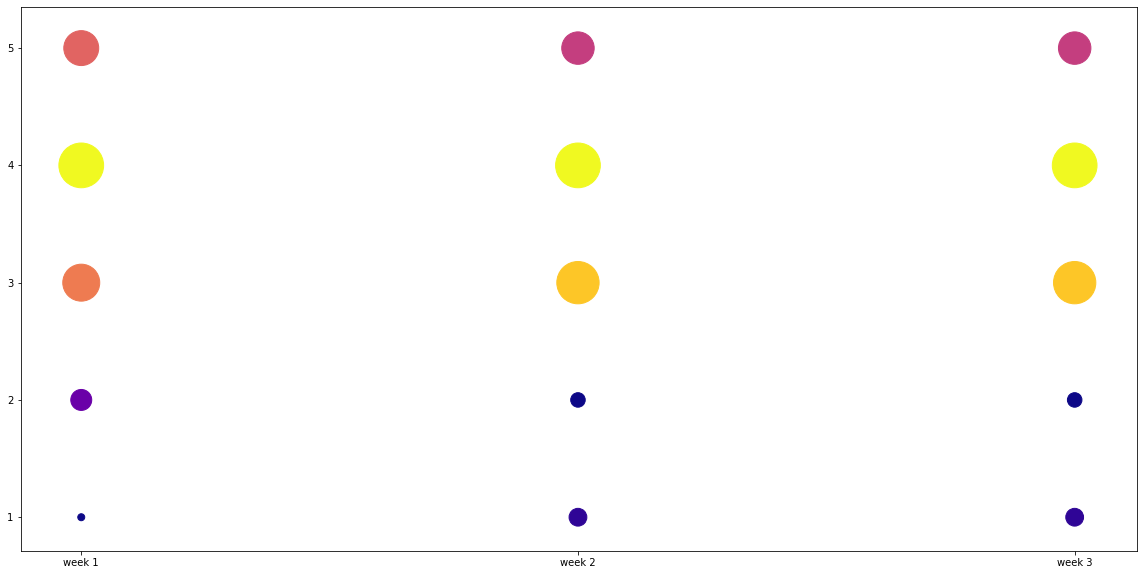

In [440]:
fig, ax = plt.subplots(figsize=(20, 10))

plot_confidence(student['response'], label=1, ax=ax)
plot_confidence(student['response_2'], label=2, ax=ax)
plot_confidence(student['response_3'], label=3, ax=ax)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['week 1', 'week 2', 'week 3']);

All student's answers, in a generic comparison.
This graph is the same one as the histogram in graph 2
but it is vertical instead of a horizontal histogram.

It is a generic enough plot that allows us to input any filter
we may want for the students.

In [398]:
student.columns

Index(['enrolled_at', 'unenrolled_at', 'role', 'fully_participated_at',
       'purchased_statement_at', 'gender', 'country', 'age_range',
       'highest_education_level', 'employment_status', 'employment_area',
       'detected_country', 'unlimited', 'id', 'responded_at', 'archetype',
       'quiz_question', 'response', 'quiz_question_2', 'response_2',
       'quiz_question_3', 'response_3'],
      dtype='object')

In [401]:
student['employment_status'].value_counts()

Unknown              330
working_full_time     18
looking_for_work      12
self_employed          8
working_part_time      6
unemployed             4
full_time_student      4
retired                3
not_working            1
Name: employment_status, dtype: int64

In [416]:
for estat in student['employment_status'].value_counts().index:
    print(estat)

Unknown
working_full_time
looking_for_work
self_employed
working_part_time
unemployed
full_time_student
retired
not_working


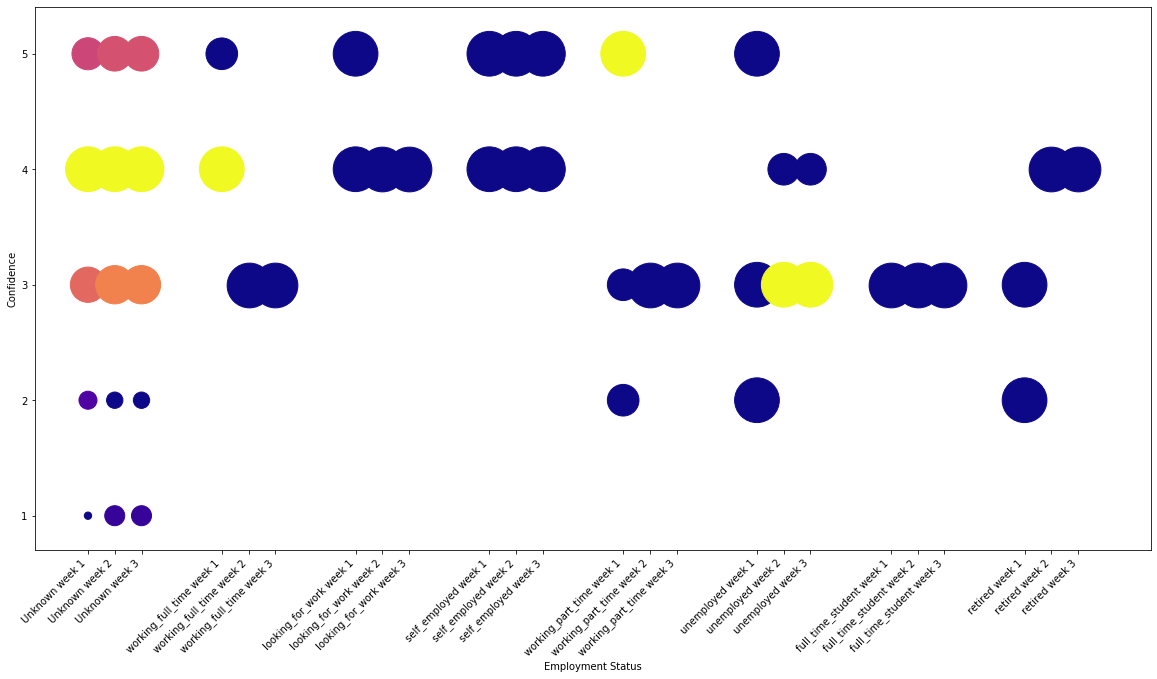

In [445]:
fig, ax = plt.subplots(figsize=(20, 10))

ticks = []
labels = []
for label, estat in enumerate(student['employment_status'].value_counts().index):
    tmp = student[student['employment_status'] == estat]
    plotted = 0
    plotted += plot_confidence(tmp['response'], label=label, ax=ax)
    plotted += plot_confidence(tmp['response_2'], label=label + .2, ax=ax)
    plotted += plot_confidence(tmp['response_3'], label=label + .4, ax=ax)
    if plotted:
        ticks += [label, label+.2, label+.4]
        labels += [f'{estat} week 1', f'{estat} week 2', f'{estat} week 3']

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Confidence')
ax.set_xlabel('Employment Status');

## Graph 3

Example of comparison graph.
Each vertical grouping is a distribution of answers by students in the label group.
Groups are always placed together for the three weeks of answers
and split (by a larger spacing between the label groups).
The ball sizes are normalized within the groups,
in this way we can compare the scatter sizes to get information about a single
label group behaviour (here employment status).
The colors are not normalized and represent the sizes of the groups.
Brighter colors (towards yellow) are the biggest groupings, here "Unknown".
Label groups with bright colors have good sample sizes,
whilst dull dark blue label groups have meaningless sample sizes.

This graph method can be reasonably easily reused.  For example, highest education level.

In [447]:
student['highest_education_level'].value_counts()

Unknown                 330
university_degree        28
university_masters       15
tertiary                  6
university_doctorate      4
secondary                 3
Name: highest_education_level, dtype: int64

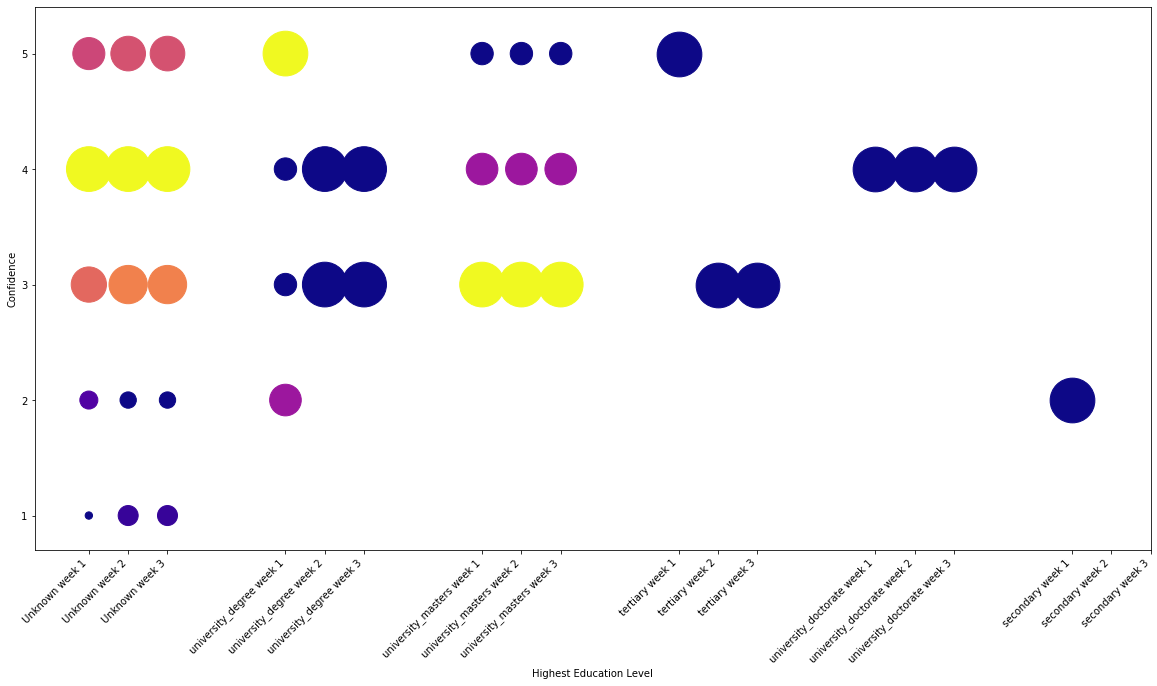

In [451]:
fig, ax = plt.subplots(figsize=(20, 10))

ticks = []
labels = []
for label, estat in enumerate(student['highest_education_level'].value_counts().index):
    tmp = student[student['highest_education_level'] == estat]
    plotted = 0
    plotted += plot_confidence(tmp['response'], label=label, ax=ax)
    plotted += plot_confidence(tmp['response_2'], label=label + .2, ax=ax)
    plotted += plot_confidence(tmp['response_3'], label=label + .4, ax=ax)
    if plotted:
        ticks += [label, label+.2, label+.4]
        labels += [f'{estat} week 1', f'{estat} week 2', f'{estat} week 3']

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Confidence')
ax.set_xlabel('Highest Education Level');

Scatter plots have the advantage of allowing one to see four dimensions at one:
comparison of two dimensions, plus size and color.